In [68]:
import pandas as pd
import numpy as np
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
import os
import zipfile
import matplotlib.pyplot as plt
from matplotlib import rc

class Gym:
    def __init__(self): 
        self.df = None
        self.regions = {"서울특별시": "Seoul", "부산광역시": "Busan", "인천광역시": "Incheon", "대구광역시": "Daegu", "대전광역시": "Daejeon", "광주광역시": "Gwangju", "울산광역시": "Ulsan", "세종특별자치시": "Sejong", "경기도": "Gyeonggi", "강원도": "Gangwon", "충청북도": "Chungbuk", "충청남도": "Chungnam", "전라북도": "Jeonbuk", "전라남도": "Jeonnam", "경상북도": "Gyeongbuk", "경상남도": "Gyeongnam", "제주특별자치도": "Jeju"}
        
    def get_zip(self): # 크롤링을 통해 웹에서 zip파일을 가져온다.
        self.condition = {'savefile.default_directory': os.getcwd(), 'download.default_directory': os.getcwd()}
        self.chrome_options = webdriver.ChromeOptions()
        self.chrome_options.add_experimental_option('prefs', self.condition)
        self.driver = webdriver.Chrome(options=self.chrome_options) # 크롬드라이버 설치한 경로 작성 필요 
        self.driver.get("https://www.data.go.kr/data/15045048/fileData.do#")
        self.download_btn = self.driver.find_element(By.XPATH, '//*[@id="data-url-btn"]')
        self.download_url = self.download_btn.get_attribute('href')
        self.driver.get(self.download_url)
        print("zip 파일 다운로드 완료")
        
    def decompress_zip(self): # 해당 디렉토리에 있는 zip파일 압축해제
        self.file = '10_42_01_P_CSV.zip'
        with zipfile.ZipFile(self.file, 'r') as z:
            infos = z.infolist()
            for info in infos:
                info.filename = info.filename.encode('cp437').decode('euc-kr')
                z.extract(info)
        print("압축 해제 완료")
    
    def csv_to_df(self, csv= './fulldata_10_42_01_P_체력단련장업.csv'): # csv 파일을 df로 불러오기
        self.group = pd.read_csv(csv, chunksize = 1000, encoding='cp949')
        self.group = list(self.group)
        self.df = pd.concat(self.group)
        print("데이터프레임(df) 생성 완료")
        return self.df

class Modify(Gym):
    
    def extract_cols(self):
        self.df_necessary = self.df.loc[:,['사업장명', '인허가일자', '인허가취소일자','휴업시작일자', '휴업종료일자', '폐업일자', '영업상태명', '소재지전체주소', '도로명전체주소']]
        print("필요한 컬럼 추출 완료")
        return self.df_necessary
        
    def create_cols(self):
        self.df_necessary.loc[:,'주소'] = np.where(self.df_necessary.loc[:,'도로명전체주소'].notnull() , self.df_necessary['도로명전체주소'], self.df_necessary['소재지전체주소'])
        self.df_necessary.loc[:,'폐업,전출,휴업,취소,말소여부'] = np.where(self.df_necessary.loc[:,'인허가취소일자'].notnull() | self.df_necessary.loc[:,'휴업시작일자'].notnull() | self.df_necessary.loc[:,'폐업일자'].notnull(), 1, 0)
        self.df_necessary.loc[:, '폐업,전출,휴업,취소,말소일자'] = self.df_necessary.loc[:, ['인허가취소일자', '폐업일자', '휴업시작일자']].max(axis=1)
        print("필요한 컬럼 가공 및 추가 완료")
        return self.df_necessary
        
    def convert_type(self, cols=['폐업,전출,휴업,취소,말소일자', '인허가일자'], d_format='%Y%m%d'):
        for col in cols:
            self.df_necessary.loc[:,col] = pd.to_datetime(self.df_necessary.loc[:,col], format= d_format)
        print("날짜 형식으로 형변환 완료")
        return self.df_necessary
            
    def extract_year(self, cols = ['폐업,전출,휴업,취소,말소일자', '인허가일자'], date='Y'):
        for col in cols:
            self.df_necessary.loc[:,col[0:-2]+'연도'] = self.df_necessary.loc[:, col].dt.to_period(date)
        print("날짜 형식에서 연도만 추출 완료")
        return self.df_necessary
    
    def create_region_df(self):
        for region in self.regions.keys():
            globals()['df_{}'.format(self.regions[region])] = self.df_necessary[(self.df_necessary['주소'].str.contains(region, na = False))]
        print("지역별 데이터프레임 생성 완료")
        
    def region_df_to_csv(self, region):
        globals()['df_{}'.format(self.regions[region])].to_csv(f"./{region}+{self.regions[region]}.csv", sep = ",", index = False, mode= "w",encoding='cp949')
        
    def show_graph(self, region):
        rc('font', family='AppleGothic')
        if region == '전국':
            self.df_necessary.groupby(self.df_necessary.loc[:,'인허가연도'])['인허가연도'].count().plot(c = '#4CAF50', marker = 'o', ms = 5)
            self.df_necessary.groupby(self.df_necessary.loc[:,'폐업,전출,휴업,취소,말소연도'])['폐업,전출,휴업,취소,말소여부'].sum().plot(color = 'r', ls = ':', marker = 'o', ms = 3)
            plt.xlim('1981', '2022')
            plt.xlabel("연도")
            plt.ylabel("업장 수")
            plt.title(f"{region} 연도별 체력단련장업 추이")
            plt.show()
        else:
            globals()['df_{}'.format(self.regions[region])].groupby(self.df_necessary.loc[:,'인허가연도'])['인허가연도'].count().plot(c = '#4CAF50', marker = 'o', ms = 5)
            globals()['df_{}'.format(self.regions[region])].groupby(self.df_necessary.loc[:,'폐업,전출,휴업,취소,말소연도'])['폐업,전출,휴업,취소,말소여부'].sum().plot(color = 'r', ls = ':', marker = 'o', ms = 3)
            plt.xlim('1981', '2022')
            plt.xlabel("연도")
            plt.ylabel("업장 수")
            plt.title(f"{region} 연도별 체력단련장업 추이")
            plt.show()
    
                

In [59]:
b = Modify()

In [8]:
b.get_zip()

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=107.0.5304.121)
Stacktrace:
0   chromedriver                        0x000000010955c2c8 chromedriver + 4752072
1   chromedriver                        0x00000001094dc463 chromedriver + 4228195
2   chromedriver                        0x000000010913fb18 chromedriver + 441112
3   chromedriver                        0x000000010911c210 chromedriver + 295440
4   chromedriver                        0x00000001091a1e3d chromedriver + 843325
5   chromedriver                        0x00000001091b5719 chromedriver + 923417
6   chromedriver                        0x000000010919db33 chromedriver + 826163
7   chromedriver                        0x000000010916e9fd chromedriver + 633341
8   chromedriver                        0x0000000109170051 chromedriver + 639057
9   chromedriver                        0x000000010952930e chromedriver + 4543246
10  chromedriver                        0x000000010952da88 chromedriver + 4561544
11  chromedriver                        0x00000001095356df chromedriver + 4593375
12  chromedriver                        0x000000010952e8fa chromedriver + 4565242
13  chromedriver                        0x00000001095042cf chromedriver + 4391631
14  chromedriver                        0x000000010954d5b8 chromedriver + 4691384
15  chromedriver                        0x000000010954d739 chromedriver + 4691769
16  chromedriver                        0x000000010956381e chromedriver + 4782110
17  libsystem_pthread.dylib             0x00007ff81a5464e1 _pthread_start + 125
18  libsystem_pthread.dylib             0x00007ff81a541f6b thread_start + 15


In [9]:
b.decompress_zip()

압축 해제 완료


In [60]:
b.csv_to_df()

데이터프레임(df) 생성 완료


,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,문화체육업종명,공사립구분명,보험가입여부코드,지도자수,건축물동수,건축물연면적,회원모집총인원,세부업종명,법인명,Unnamed: 37
0,1,체력단련장업,10_42_01_P,4640000,CDFH3301062008000012,20080923,NaN,4,취소/말소/만료/정지/중지,31,...,체력단련장업,사립,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,체력단련장업,10_42_01_P,4970000,CDFH3301062003000002,20030212,20200622.0,4,취소/말소/만료/정지/중지,31,...,체력단련장업,사립,NaN,NaN,NaN,72.00,NaN,NaN,NaN,NaN
2,3,체력단련장업,10_42_01_P,4970000,CDFH3301062006000001,20060612,20200608.0,4,취소/말소/만료/정지/중지,31,...,체력단련장업,사립,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,체력단련장업,10_42_01_P,4970000,CDFH3301062007000002,20071107,20200608.0,4,취소/말소/만료/정지/중지,31,...,체력단련장업,사립,NaN,NaN,NaN,2801.07,NaN,NaN,NaN,NaN
4,5,체력단련장업,10_42_01_P,4030000,CDFH3301062004000003,20040331,20131221.0,4,취소/말소/만료/정지/중지,31,...,체력단련장업,사립,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20745,20746,체력단련장업,10_42_01_P,4040000,CDFH3301062010000001,20100125,NaN,2,휴업,02,...,체력단련장업,사립,NaN,NaN,NaN,2676.50,NaN,NaN,NaN,NaN
20746,20747,체력단련장업,10_42_01_P,3130000,CDFH3301062008000007,20081104,NaN,2,휴업,02,...,체력단련장업,사립,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20747,20748,체력단련장업,10_42_01_P,3220000,CDFH3301062017000021,20170504,NaN,2,휴업,02,...,체력단련장업,사립,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
20748,20749,체력단련장업,10_42_01_P,4900000,CDFH3301062009000001,20090224,NaN,1,영업/정상,BBBB,...,체력단련장업,사립,Y,1.0,1.0,193.00,NaN,NaN,NaN,NaN


In [61]:
b.extract_cols()

필요한 컬럼 추출 완료


,사업장명,인허가일자,인허가취소일자,휴업시작일자,휴업종료일자,폐업일자,영업상태명,소재지전체주소,도로명전체주소
0,우먼파워에어로빅,20080923,NaN,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라북도 전주시 덕진구 우아동3가 732-5번지,전라북도 전주시 덕진구 백제대로 781 (우아동3가)
1,홍농 헬스클럽,20030212,20200622.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라남도 영광군 홍농읍 상하리 539-1번지,전라남도 영광군 홍농읍 상하길 3
2,리더스 스포츠클럽,20060612,20200608.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라남도 영광군 영광읍 단주리 630-9번지,전라남도 영광군 영광읍 옥당로 169
3,태정헬스,20071107,20200608.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라남도 영광군 영광읍 백학리 47번지 6층,전라남도 영광군 영광읍 현암길 45-7
4,탑 휘트니스,20040331,20131221.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,경기도 의왕시 삼동 277-6번지,경기도 의왕시 부곡복지관길 6 (삼동)
...,...,...,...,...,...,...,...,...,...
20745,스파르타짐,20100125,NaN,NaN,NaN,NaN,휴업,경기도 하남시 덕풍동 319-2 남도빌딩,"경기도 하남시 하남대로 837, 남도빌딩 4층 (덕풍동)"
20746,(주)스포츠아트필피트니스,20081104,NaN,20130508.0,20130901.0,NaN,휴업,"서울특별시 마포구 상암동 1605번지 누리꿈스퀘어 지층 B1001~1005,1015...","서울특별시 마포구 월드컵북로 396, 지하1층 B1001~1005호 (상암동, 누리..."
20747,디앤브이 피트니스,20170504,NaN,20191010.0,20201009.0,NaN,휴업,서울특별시 강남구 역삼동 783-18번지 제이케이빌딩,"서울특별시 강남구 언주로65길 13, 3층 (역삼동, 제이케이빌딩)"
20748,대영청소년문화진흥원(주),20090224,NaN,NaN,NaN,NaN,영업/정상,전라남도 화순군 북면 옥리 499-3번지,전라남도 화순군 북면 옥리길 27-20


In [62]:
b.create_cols()

필요한 컬럼 가공 및 추가 완료


,사업장명,인허가일자,인허가취소일자,휴업시작일자,휴업종료일자,폐업일자,영업상태명,소재지전체주소,도로명전체주소,주소,"폐업,전출,휴업,취소,말소여부","폐업,전출,휴업,취소,말소일자"
0,우먼파워에어로빅,20080923,NaN,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라북도 전주시 덕진구 우아동3가 732-5번지,전라북도 전주시 덕진구 백제대로 781 (우아동3가),전라북도 전주시 덕진구 백제대로 781 (우아동3가),0,NaN
1,홍농 헬스클럽,20030212,20200622.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라남도 영광군 홍농읍 상하리 539-1번지,전라남도 영광군 홍농읍 상하길 3,전라남도 영광군 홍농읍 상하길 3,1,20200622.0
2,리더스 스포츠클럽,20060612,20200608.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라남도 영광군 영광읍 단주리 630-9번지,전라남도 영광군 영광읍 옥당로 169,전라남도 영광군 영광읍 옥당로 169,1,20200608.0
3,태정헬스,20071107,20200608.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라남도 영광군 영광읍 백학리 47번지 6층,전라남도 영광군 영광읍 현암길 45-7,전라남도 영광군 영광읍 현암길 45-7,1,20200608.0
4,탑 휘트니스,20040331,20131221.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,경기도 의왕시 삼동 277-6번지,경기도 의왕시 부곡복지관길 6 (삼동),경기도 의왕시 부곡복지관길 6 (삼동),1,20131221.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20745,스파르타짐,20100125,NaN,NaN,NaN,NaN,휴업,경기도 하남시 덕풍동 319-2 남도빌딩,"경기도 하남시 하남대로 837, 남도빌딩 4층 (덕풍동)","경기도 하남시 하남대로 837, 남도빌딩 4층 (덕풍동)",0,NaN
20746,(주)스포츠아트필피트니스,20081104,NaN,20130508.0,20130901.0,NaN,휴업,"서울특별시 마포구 상암동 1605번지 누리꿈스퀘어 지층 B1001~1005,1015...","서울특별시 마포구 월드컵북로 396, 지하1층 B1001~1005호 (상암동, 누리...","서울특별시 마포구 월드컵북로 396, 지하1층 B1001~1005호 (상암동, 누리...",1,20130508.0
20747,디앤브이 피트니스,20170504,NaN,20191010.0,20201009.0,NaN,휴업,서울특별시 강남구 역삼동 783-18번지 제이케이빌딩,"서울특별시 강남구 언주로65길 13, 3층 (역삼동, 제이케이빌딩)","서울특별시 강남구 언주로65길 13, 3층 (역삼동, 제이케이빌딩)",1,20191010.0
20748,대영청소년문화진흥원(주),20090224,NaN,NaN,NaN,NaN,영업/정상,전라남도 화순군 북면 옥리 499-3번지,전라남도 화순군 북면 옥리길 27-20,전라남도 화순군 북면 옥리길 27-20,0,NaN


In [63]:
b.convert_type()

날짜 형식으로 형변환 완료


,사업장명,인허가일자,인허가취소일자,휴업시작일자,휴업종료일자,폐업일자,영업상태명,소재지전체주소,도로명전체주소,주소,"폐업,전출,휴업,취소,말소여부","폐업,전출,휴업,취소,말소일자"
0,우먼파워에어로빅,2008-09-23,NaN,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라북도 전주시 덕진구 우아동3가 732-5번지,전라북도 전주시 덕진구 백제대로 781 (우아동3가),전라북도 전주시 덕진구 백제대로 781 (우아동3가),0,NaT
1,홍농 헬스클럽,2003-02-12,20200622.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라남도 영광군 홍농읍 상하리 539-1번지,전라남도 영광군 홍농읍 상하길 3,전라남도 영광군 홍농읍 상하길 3,1,2020-06-22
2,리더스 스포츠클럽,2006-06-12,20200608.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라남도 영광군 영광읍 단주리 630-9번지,전라남도 영광군 영광읍 옥당로 169,전라남도 영광군 영광읍 옥당로 169,1,2020-06-08
3,태정헬스,2007-11-07,20200608.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라남도 영광군 영광읍 백학리 47번지 6층,전라남도 영광군 영광읍 현암길 45-7,전라남도 영광군 영광읍 현암길 45-7,1,2020-06-08
4,탑 휘트니스,2004-03-31,20131221.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,경기도 의왕시 삼동 277-6번지,경기도 의왕시 부곡복지관길 6 (삼동),경기도 의왕시 부곡복지관길 6 (삼동),1,2013-12-21
...,...,...,...,...,...,...,...,...,...,...,...,...
20745,스파르타짐,2010-01-25,NaN,NaN,NaN,NaN,휴업,경기도 하남시 덕풍동 319-2 남도빌딩,"경기도 하남시 하남대로 837, 남도빌딩 4층 (덕풍동)","경기도 하남시 하남대로 837, 남도빌딩 4층 (덕풍동)",0,NaT
20746,(주)스포츠아트필피트니스,2008-11-04,NaN,20130508.0,20130901.0,NaN,휴업,"서울특별시 마포구 상암동 1605번지 누리꿈스퀘어 지층 B1001~1005,1015...","서울특별시 마포구 월드컵북로 396, 지하1층 B1001~1005호 (상암동, 누리...","서울특별시 마포구 월드컵북로 396, 지하1층 B1001~1005호 (상암동, 누리...",1,2013-05-08
20747,디앤브이 피트니스,2017-05-04,NaN,20191010.0,20201009.0,NaN,휴업,서울특별시 강남구 역삼동 783-18번지 제이케이빌딩,"서울특별시 강남구 언주로65길 13, 3층 (역삼동, 제이케이빌딩)","서울특별시 강남구 언주로65길 13, 3층 (역삼동, 제이케이빌딩)",1,2019-10-10
20748,대영청소년문화진흥원(주),2009-02-24,NaN,NaN,NaN,NaN,영업/정상,전라남도 화순군 북면 옥리 499-3번지,전라남도 화순군 북면 옥리길 27-20,전라남도 화순군 북면 옥리길 27-20,0,NaT


In [64]:
b.extract_year(['폐업,전출,휴업,취소,말소일자', '인허가일자'],'Y')

날짜 형식에서 연도만 추출 완료


,사업장명,인허가일자,인허가취소일자,휴업시작일자,휴업종료일자,폐업일자,영업상태명,소재지전체주소,도로명전체주소,주소,"폐업,전출,휴업,취소,말소여부","폐업,전출,휴업,취소,말소일자","폐업,전출,휴업,취소,말소연도",인허가연도
0,우먼파워에어로빅,2008-09-23,NaN,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라북도 전주시 덕진구 우아동3가 732-5번지,전라북도 전주시 덕진구 백제대로 781 (우아동3가),전라북도 전주시 덕진구 백제대로 781 (우아동3가),0,NaT,NaT,2008
1,홍농 헬스클럽,2003-02-12,20200622.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라남도 영광군 홍농읍 상하리 539-1번지,전라남도 영광군 홍농읍 상하길 3,전라남도 영광군 홍농읍 상하길 3,1,2020-06-22,2020,2003
2,리더스 스포츠클럽,2006-06-12,20200608.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라남도 영광군 영광읍 단주리 630-9번지,전라남도 영광군 영광읍 옥당로 169,전라남도 영광군 영광읍 옥당로 169,1,2020-06-08,2020,2006
3,태정헬스,2007-11-07,20200608.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,전라남도 영광군 영광읍 백학리 47번지 6층,전라남도 영광군 영광읍 현암길 45-7,전라남도 영광군 영광읍 현암길 45-7,1,2020-06-08,2020,2007
4,탑 휘트니스,2004-03-31,20131221.0,NaN,NaN,NaN,취소/말소/만료/정지/중지,경기도 의왕시 삼동 277-6번지,경기도 의왕시 부곡복지관길 6 (삼동),경기도 의왕시 부곡복지관길 6 (삼동),1,2013-12-21,2013,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20745,스파르타짐,2010-01-25,NaN,NaN,NaN,NaN,휴업,경기도 하남시 덕풍동 319-2 남도빌딩,"경기도 하남시 하남대로 837, 남도빌딩 4층 (덕풍동)","경기도 하남시 하남대로 837, 남도빌딩 4층 (덕풍동)",0,NaT,NaT,2010
20746,(주)스포츠아트필피트니스,2008-11-04,NaN,20130508.0,20130901.0,NaN,휴업,"서울특별시 마포구 상암동 1605번지 누리꿈스퀘어 지층 B1001~1005,1015...","서울특별시 마포구 월드컵북로 396, 지하1층 B1001~1005호 (상암동, 누리...","서울특별시 마포구 월드컵북로 396, 지하1층 B1001~1005호 (상암동, 누리...",1,2013-05-08,2013,2008
20747,디앤브이 피트니스,2017-05-04,NaN,20191010.0,20201009.0,NaN,휴업,서울특별시 강남구 역삼동 783-18번지 제이케이빌딩,"서울특별시 강남구 언주로65길 13, 3층 (역삼동, 제이케이빌딩)","서울특별시 강남구 언주로65길 13, 3층 (역삼동, 제이케이빌딩)",1,2019-10-10,2019,2017
20748,대영청소년문화진흥원(주),2009-02-24,NaN,NaN,NaN,NaN,영업/정상,전라남도 화순군 북면 옥리 499-3번지,전라남도 화순군 북면 옥리길 27-20,전라남도 화순군 북면 옥리길 27-20,0,NaT,NaT,2009


In [65]:
b.create_region_df()

지역별 데이터프레임 생성 완료


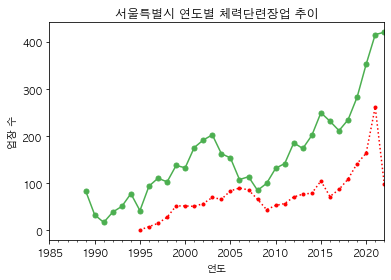

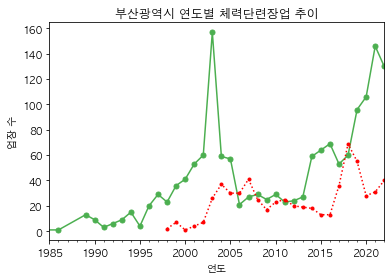

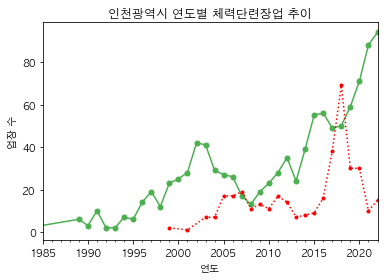

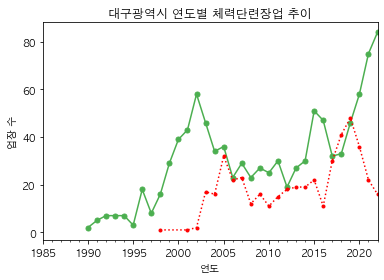

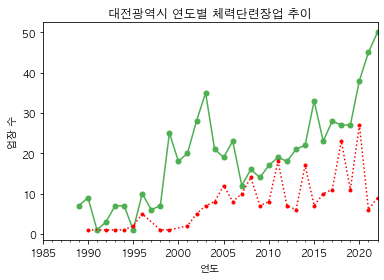

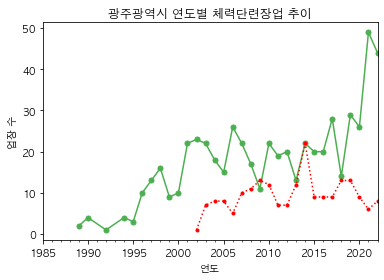

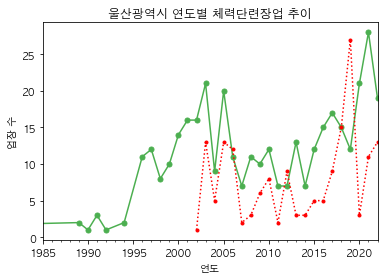

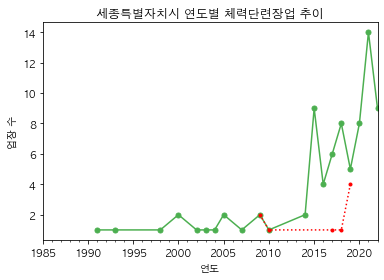

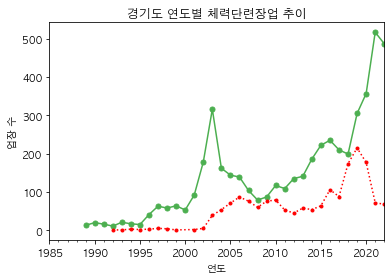

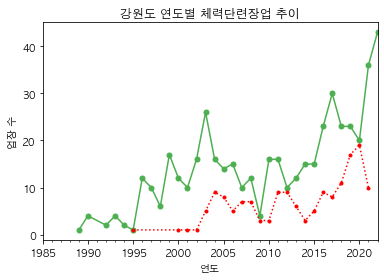

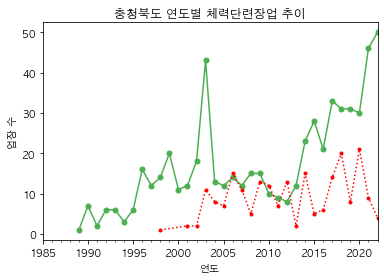

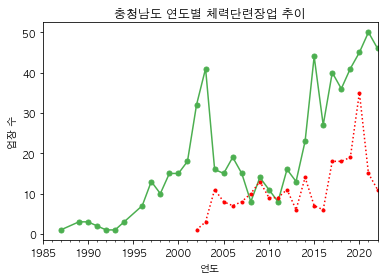

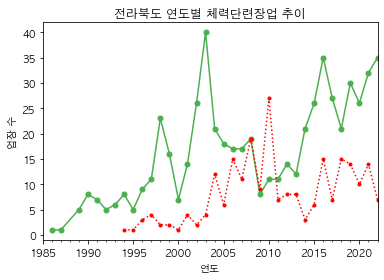

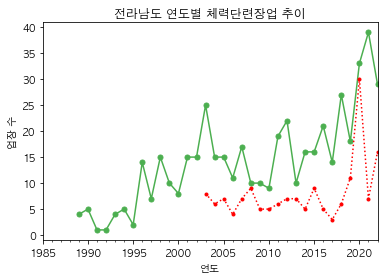

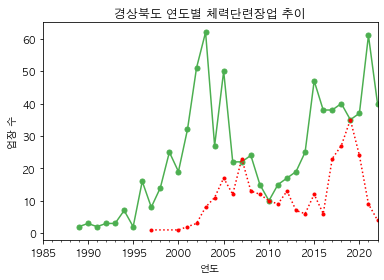

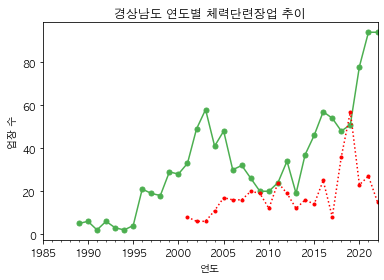

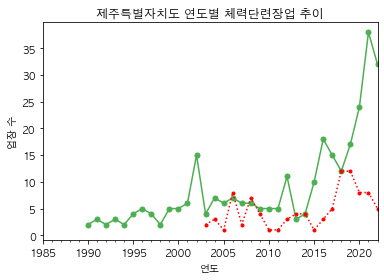

In [66]:
for region in b.regions.keys():
    b.region_df_to_csv(region)
    b.show_graph(region)

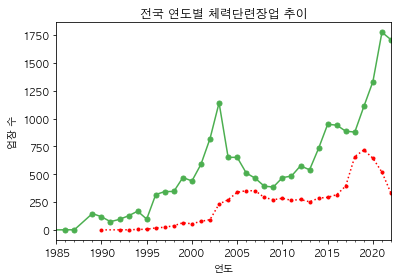

In [67]:
b.show_graph('전국')